# Feature Building!
This notebook will involve efforts to create new features out of the text data fields

### Get data from Kaggle, clean, and split

In [1]:
import json
import csv
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib.colors import ListedColormap
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from subprocess import check_output
#from wordcloud import WordCloud, STOPWORDS

#ML
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from sklearn.mixture import GaussianMixture

from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

from sklearn.pipeline import make_pipeline

%matplotlib inline
plt.style.use('bmh')

#1. Train Data
with open('../data/train.json') as fin:
    trainjson = json.load(fin)
train = pd.io.json.json_normalize(trainjson)
#2. Test Data
with open('../data/test.json') as fin:
    testjson = json.load(fin) 
test = pd.io.json.json_normalize(testjson)

print("Kaggle Train Shape:", train.shape)
print("Kaggle Test Shape:", test.shape)

train_labels_master = train[['requester_received_pizza']]
train_data_master = train[test.columns & train.columns]
train_only_data_master = train[train.columns[~train.columns.isin(test.columns)]].drop(['requester_received_pizza'], axis = 1)

train_data_master = train_data_master.assign(
    unix_timestamp_of_request = pd.to_datetime(
        train_data_master.unix_timestamp_of_request, unit = "s"),
    unix_timestamp_of_request_utc = pd.to_datetime(
        train_data_master.unix_timestamp_of_request_utc, unit = "s"))

# Isolate the text column for the training and dev dataframes
x_train, x_test, y_train, y_test = train_test_split(
   train_data_master,
   train_labels_master.values.ravel(), test_size=0.29, random_state=0)

print("Our Train Shape:", x_train.shape)
print("Our Test Shape:", x_test.shape)


Kaggle Train Shape: (4040, 32)
Kaggle Test Shape: (1631, 17)
Our Train Shape: (2868, 17)
Our Test Shape: (1172, 17)


### Model report function

In [2]:
def model_report(title, y_test, predictions):

    """
    Output: Classification report, confusion matrix, and ROC curve
    """
    print(title)
    print("---------")
    print(classification_report(y_test, predictions))

    cm = metrics.confusion_matrix(y_test, predictions)
    plt.figure(figsize=(3,3))
    sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Accuracy: {0}'.format(round(metrics.accuracy_score(y_test, predictions),2))
    plt.title(all_sample_title, size = 15)
    plt.show()
    
    fpr, tpr, threshold = metrics.roc_curve(y_test, predictions)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

### Make features function

In [3]:
def make_features(vocab):
    # this function takes as input a string list of words
    # it outputs four np.arrays: 
    # 1. train data feature dealing with title text
    # 2. train data feature dealing with body text
    # 3. test data feature dealing with title text
    # 4. test data feature dealing with body text

    # initialize feature variables to 0
    train_feature_title = np.zeros(shape = (x_train.shape[0],1))
    train_feature_body = np.zeros(shape = (x_train.shape[0],1))
    test_feature_title = np.zeros(shape = (x_test.shape[0],1))
    test_feature_body = np.zeros(shape = (x_test.shape[0],1))

    # look through each training sample for occurences of vocab words
    for sample_row in range(x_train.shape[0]):
        title_text = str(x_train.request_title.iloc[sample_row]).lower()
        body_text = str(x_train.request_text_edit_aware.iloc[sample_row]).lower() 
    
        for word in vocab:
            if word in title_text:
                train_feature_title[sample_row] = 1
            if word in body_text:
                train_feature_body[sample_row] = 1            
        
    # look through each test sample for occurences of vocab words
    for sample_row in range(x_test.shape[0]):
        title_text = str(x_test.request_title.iloc[sample_row]).lower()
        body_text = str(x_test.request_text_edit_aware.iloc[sample_row]).lower()

        for word in vocab:
            if word in title_text:
                test_feature_title[sample_row] = 1
            if word in body_text:
                test_feature_body[sample_row] = 1

    return(train_feature_title, train_feature_body, test_feature_title, test_feature_body)

### 1. Sickness features
The idea here: People mentioning that they or their family are suffering from a sickness may win a lot of sympathy and have an easier path to a pizza. These feature will load in a comprehensive list of disease names and test to see if the text body or text title contains an occurence of them. 

In [19]:
#disease_list = []
#with open('../data/diseases.csv', mode='r') as fin:
#    reader = csv.reader(fin)
#    for row in reader:
#        disease_list.append(row[0])
#        #diseases[row[0].lower()] = 0 # lowercase         
#disease_list = list(set(disease_list)) # de-dup

vocab = ['sick','disease','diagnosed','doctor','terminal','died','dying','death','dead','sickness','health','medical', 
        'hospice','doctors']
train_disease_title, train_disease_body, test_disease_title, test_disease_body = make_features(vocab)


### 2. Repayment features
The idea here: Submitted offers to repay or trade or barter in some manner. 

In [5]:
vocab = ['barter','trade','repay', 'paycheck', 'paypal', 'spot','credits', 'credit', 'game', 'bitcoin']
train_repay_title, train_repay_body, test_repay_title, test_repay_body = make_features(vocab)
    

### 3. Feed me! features
The idea here: A lot of people just straight say I'm hungry, feed me.

In [6]:
vocab = ['hungry','starving','crave','craving','mmm']
train_feedme_title, train_feedme_body, test_feedme_title, test_feedme_body = make_features(vocab)


### 4. Assholery features
The idea here: Using crass language

In [7]:
vocab = ['fuck','shit','cunt','crap','dick','pussy','asshole','ass']
train_swears_title, train_swears_body, test_swears_title, test_swears_body = make_features(vocab)


### 5. Religious features
The idea here: I'm a good Christian, now buy me a pizza!

In [23]:
vocab = ['god', 'prayer','prayers','holy','jesus','christ','christian','religion','moral','savior','righteous'
        ,'bless','blessed','blessing','faith','lord']
train_god_title, train_god_body, test_god_title, test_god_body = make_features(vocab)



### 6. Gratitude / politeness features
The idea here: What's the magic word?

In [16]:
vocab = ['please', 'thank', 'thanks']
train_polite_title, train_polite_body, test_polite_title, test_polite_body = make_features(vocab)

### 7. Politics
The idea here: Could be big turnoff

In [27]:
vocab = ['democrat', 'republican','obama', 'trump', 'hillary', 'clinton', 'liberal','conservative','libertarian','libs','bush','president','romney']
train_politics_title, train_politics_body, test_politics_title, test_politics_body = make_features(vocab)

### 8. Gender
The idea here: Chicks get free food

In [46]:
vocab = ['hot','hawt','sexy','woman','chick','babe','lonely']
train_chicks_title, train_chicks_body, test_chicks_title, test_chicks_body = make_features(vocab)

### 9. Family
The idea here: Feed my family, for the kids

In [48]:
vocab = ['family','kids','kid','children','child','baby','wife','school']
train_family_title, train_family_body, test_family_title, test_family_body = make_features(vocab)

### Fit model with added features!

Logistic Regression (baseline)
---------
             precision    recall  f1-score   support

      False       0.77      0.99      0.87       891
       True       0.68      0.06      0.11       281

avg / total       0.75      0.77      0.69      1172



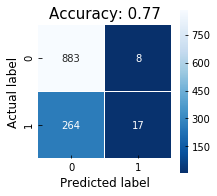

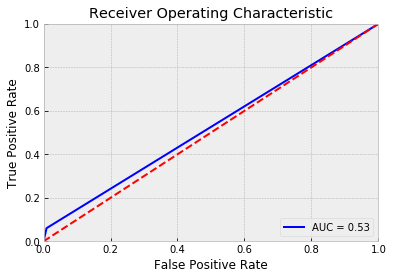

Logistic Regression (with engineered features)
---------
             precision    recall  f1-score   support

      False       0.77      0.99      0.87       891
       True       0.67      0.06      0.12       281

avg / total       0.75      0.77      0.69      1172



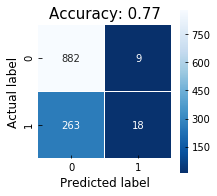

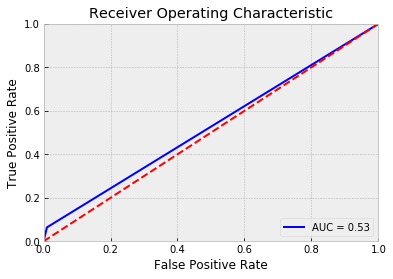

In [51]:
#Normalize all fields (numeric)
min_max_scaler = preprocessing.MinMaxScaler()
x_train_scaled = min_max_scaler.fit_transform(
    x_train.select_dtypes(include = ['float64', 'int64','datetime64[ns]']).apply(pd.to_numeric).values)
x_test_scaled = min_max_scaler.fit_transform(
    x_test.select_dtypes(include = ['float64', 'int64','datetime64[ns]']).apply(pd.to_numeric).values)

#Train Baseline Model
logisticRegr = LogisticRegression()
logisticRegr.fit(x_train_scaled, y_train)
predictions = logisticRegr.predict(x_test_scaled)

#Output Baseline model report
model_report("Logistic Regression (baseline)",y_test, predictions)

# add new bernoulli features to the train and test data
# x_train_full = np.append(x_train_scaled, train_disease_title, 1)
# x_train_full = np.append(x_train_scaled, train_disease_body, 1)
# x_test_full = np.append(x_test_scaled, test_disease_title, 1)
# x_test_full = np.append(x_test_scaled, test_disease_body, 1)
#x_train_full = np.append(x_train_scaled, train_repay_title, 1)
#x_train_full = np.append(x_train_scaled, train_repay_body, 1)
#x_test_full = np.append(x_test_scaled, test_repay_title, 1)
#x_test_full = np.append(x_test_scaled, test_repay_body, 1)
#x_train_full = np.append(x_train_scaled, train_feedme_title, 1)
#x_train_full = np.append(x_train_scaled, train_feedme_body, 1)
#x_test_full = np.append(x_test_scaled, test_feedme_title, 1)
#x_test_full = np.append(x_test_scaled, test_feedme_body, 1)
#x_train_full = np.append(x_train_scaled, train_swears_title, 1)
#x_train_full = np.append(x_train_scaled, train_swears_body, 1)
#x_test_full = np.append(x_test_scaled, test_swears_title, 1)
#x_test_full = np.append(x_test_scaled, test_swears_body, 1)
# x_train_full = np.append(x_train_scaled, train_god_title, 1)
# x_train_full = np.append(x_train_scaled, train_god_body, 1)
# x_test_full = np.append(x_test_scaled, test_god_title, 1)
# x_test_full = np.append(x_test_scaled, test_god_body, 1)
x_train_full = np.append(x_train_scaled, train_polite_title, 1)
x_train_full = np.append(x_train_scaled, train_polite_body, 1)
x_test_full = np.append(x_test_scaled, test_polite_title, 1)
x_test_full = np.append(x_test_scaled, test_polite_body, 1)
#x_train_full = np.append(x_train_scaled, train_politics_title, 1)
#x_train_full = np.append(x_train_scaled, train_politics_body, 1)
#x_test_full = np.append(x_test_scaled, test_politics_title, 1)
#x_test_full = np.append(x_test_scaled, test_politics_body, 1)
# x_train_full = np.append(x_train_scaled, train_chicks_title, 1)
# x_train_full = np.append(x_train_scaled, train_chicks_body, 1)
# x_test_full = np.append(x_test_scaled, test_chicks_title, 1)
# x_test_full = np.append(x_test_scaled, test_chicks_body, 1)
# x_train_full = np.append(x_train_scaled, train_family_title, 1)
# x_train_full = np.append(x_train_scaled, train_family_body, 1)
# x_test_full = np.append(x_test_scaled, test_family_title, 1)
# x_test_full = np.append(x_test_scaled, test_family_body, 1)

#Train Baseline Model
logisticRegr = LogisticRegression()
logisticRegr.fit(x_train_full, y_train)
predictions = logisticRegr.predict(x_test_full)

#Output Baseline model report
model_report("Logistic Regression (with engineered features)",y_test, predictions)


# Results

A lot of these make the accuracy slightly worse. The most in that respect is "repay."
One improves it slightly - polite





# After creating all these features, reduce with PCA

In [12]:
def train_gmm(svd_comps = 2, gmm_comps = 4, cov_type = 'full', sparse = True):
    
    # project data to few dimensions using SVD if sparse, PCA if dense
    if (sparse): svd_test = TruncatedSVD(n_components=svd_comps)
    else: svd_test = PCA(n_components=svd_comps)
    svd_test_ft = svd_test.fit_transform(x_test_full)
    if (sparse): svd_train = TruncatedSVD(n_components=svd_comps)
    else: svd_train = PCA(n_components=svd_comps)
    svd_train_ft = svd_train.fit_transform(x_train_full)

    # create two sets of svd data, one that's positively labeled, one that's negatively labeled
    pos_svd = svd_train_ft[y_train == 1]
    neg_svd = svd_train_ft[y_train == 0]
    
    # fit a GMM for pos and neg datasets
    gmm_pos = GaussianMixture(n_components=gmm_comps, covariance_type=cov_type) 
    gmm_fit_pos = gmm_pos.fit(pos_svd)
    gmm_neg = GaussianMixture(n_components=gmm_comps, covariance_type=cov_type) 
    gmm_fit_neg = gmm_neg.fit(neg_svd)

    prediction = np.ndarray(shape=y_test.shape)
    
    for sample in range(svd_test_ft.shape[0]):
        pos_score = gmm_fit_pos.score(svd_test_ft[sample].reshape(1,-1))
        neg_score = gmm_fit_neg.score(svd_test_ft[sample].reshape(1,-1))
        # make pick
        if (pos_score >= neg_score): prediction[sample] = 1
        else: prediction[sample] = 0 

    # calculate accuracy
    accuracy = metrics.accuracy_score(y_test, prediction)
    # f1 = metrics.f1_score(y_test, prediction)
    print("Accuracy score for", svd_comps,"SVD comps,",gmm_comps,"GMM comps,","Covariance type",cov_type,"=",accuracy)

    return(accuracy)

def reduce(sparse = True, max_params = 50):

    def calc_limits(max_params = 50):
        # this function helps estaish the svd and gmm settings to stay within max_params

        valid_configs = [] # list of tuples (num_svd_components, num_gmm_components)

        for cov_type in ['spherical', 'diag', 'tied', 'full']:
            for svd_comp in range(1,20): 
                for gmm_comp in range(1,20): 
                    if ((svd_comp + svd_comp) * gmm_comp) * 2 <= max_params:
                        valid_configs.append((svd_comp, gmm_comp, cov_type))

        return(valid_configs)

    configs = calc_limits(max_params) # get the valid configurations

    top_accuracy_val = 0 # keeps track of top accuracy value
    top_accuracy_config = () # keeps track of config that creates top accuracy value
    
    for config in configs:
        accuracy = train_gmm(config[0], config[1], config[2])
        if accuracy > top_accuracy_val:
            top_accuracy_val = accuracy
            top_accuracy_config = config

    print("*********************************************************************************")
    print("The best accuracy score is", top_accuracy_val)
    print("To get it, set SVD comps to", top_accuracy_config[0], ", GMM comps to", top_accuracy_config[1],", and covariance type to", top_accuracy_config[2])




In [13]:
#reduce(sparse = False, max_params=40)